# Numerical simulations for "Information Thermodynamics for Deterministic Chemical Reaction Networks" --- driven self-assembly

## Loading modules

In [6]:
%matplotlib inline

# Modules
import math 
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import *

print(matplotlib.__version__)

3.3.4


## Parameters (physical constants and standard chemical potentials)

In [7]:
# Parameters

h      = 6.62607004e-34 # [J*s]
kb     = 1.38064852e-23   # [J/K]
c      = 299792458        # [m/s]
Na     = 6.02214086e23
Vol    = 3e-3           # [L] = 3mL
b      = 1           # [cm] = 1cm
R      = kb*Na
T      = 293

C_kJ   = 4184 # 1kCal = 4184 J


# three different scenarios for standard chemical potentials:
mi0_1 = [-2000, -3000, -4000, 9000, 11000, -11000] #from Nat. Commun. 10, 1-5 (2019)
mi0_2 = [2000, -3000, -6000, 4000, 11000, -11000] 
mi0_3 = [2000, -3000, -2000, 4000, 11000, -11000] 

## Functions for computations

In [8]:
def kinetics(mi0):
    """
    Takes standard chemical potentials as input and returns the complete set of kinetic constants for the
    driven self-assembly model. Forward rates taken from Nat. Commun. 10, 1-5 (2019).
    """
    k1F  = 5 
    k1Fm = k1F*np.exp(-(mi0[0]+mi0[4]-mi0[1])/(R*T)) 

    k2 = 1 
    k2m = k2*np.exp(-(2*mi0[1]-mi0[2])/(R*T))

    k3F = 1e-6 
    k3Fm = k3F*np.exp(-(mi0[2]-mi0[3]-2*mi0[4])/(R*T)) 

    k4 =  0.1
    k4m = k4*np.exp(-(mi0[3]-2*mi0[0])/(R*T))

    k1W = 0.001
    k1Wm = k1W*np.exp(-(mi0[0]+mi0[5]-mi0[1])/(R*T))

    k3W = 5
    k3Wm = k3W*np.exp(-(mi0[2]-mi0[3]-2*mi0[5])/(R*T))
    
    return k1F,k1Fm,k1W,k1Wm,k2,k2m,k3F,k3Fm,k3W,k3Wm,k4,k4m

def thermodynamics(ss,mi0,Aff,W0,M0):
    """
    Input: steady state concentrations, standard chemical potentials, fuel-to-waste chemical potential difference,
    waste concentration, and total concentration of monomers.
    Output: fuelling current, steady state current, energy flow, information flow, efficiency
    """
    
    k1F,k1Fm,k1W,k1Wm,k2,k2m,k3F,k3Fm,k3W,k3Wm,k4,k4m = kinetics(mi0)
    F0 = W0*np.exp((Aff*R*T-mi0[4]+mi0[5])/(R*T))

    J2f  =  ss[1]**2*k2 
    J2b  =  ss[2]*k2m 
    J1Ff =  ss[0]*(F0)*k1F 
    J1Fb =  ss[1]*k1Fm 
    J1Wf =  ss[0]*(W0)*k1W 
    J1Wb =  ss[1]*k1Wm 
    J3Ff =  ss[2]*k3F 
    J3Fb =  ss[3]*((F0)**2)*k3Fm 
    J3Wf =  ss[2]*k3W 
    J3Wb =  ss[3]*((W0)**2)*k3Wm 
    J4f  =  ss[3]*k4 
    J4b  =  ss[0]**2*k4m 
    
    ifuel = (J1Ff-J1Fb) - 2*(J3Ff - J3Fb)
    jss = ((J1Ff - J1Fb)+(J1Wf - J1Wb))/2
    eflow = jss*(2*mi0[1]-mi0[2]+mi0[3]-2*mi0[0])
    iflow = R*T*jss*np.log((ss[1]**2*ss[3])/(ss[0]**2*ss[2]))
    eff = (eflow + iflow)/(ifuel*Aff*R*T)
    
    return ifuel, jss, eflow, iflow, eff
    

def SS_solution(ss,mi0,Aff,W0,M0):
    """
    Input: guessed steady state concentrations, standard chemical potentials, fuel-to-waste chemical potential difference,
    waste concentration, and total concentration of monomers.
    Output: steady state solution.
    """
    
    k1F,k1Fm,k1W,k1Wm,k2,k2m,k3F,k3Fm,k3W,k3Wm,k4,k4m = kinetics(mi0)
    F0 = W0*np.exp((Aff*R*T-mi0[4]+mi0[5])/(R*T))
    
    M  = ss[0]
    Ma = ss[1]
    Aa = ss[2]
    A  = ss[3]
              

    H = np.empty((4))
    H[0] = -(k1F*F0 + k1W*W0)*M - 2*k4m*M**2 + (k1Fm + k1Wm)*Ma + 2*k4*A #M
    H[1] = -(k1Fm + k1Wm)*Ma - 2*k2*Ma**2 + (k1F*F0 + k1W*W0)*M + 2*k2m*Aa #Ma
    H[2] = -(k3F + k3W + k2m)*Aa + (k3Fm*F0**2 + k3Wm*W0**2)*A + k2*Ma**2 #Aa
    H[3] = (M + Ma + 2*Aa + 2*A) - M0 #conservation of monomers
    return H

# Steady state solution for different forces and related thermodynamic quantities

In [9]:
##initial conditions
W0 = 1  ; M0 = 1 #waste chemostatted (W0) and initial monomer consentrations

ChemPot = mi0_1 #select which of the three scenarios to simulate

AFF = []; M = []; Ma = []; Aa = []; A = []; Esto = []; IFUEL = []; IWASTE = []; Jss = []; POT =[];
INFOFLOW = []; EFLOW = []; DISS = []; INTEFF = []; EPSA = []

ssGuess = np.array([0.1,0.1,0.1,0.1]) #guess for initiating steady state solution

for Affinity in np.linspace(0,15,100):
    
    ss = fsolve(SS_solution,ssGuess,args=(ChemPot,Affinity,W0,M0))
    ssGuess = np.array([ss[0],ss[1],ss[2],ss[3]]) #aggiorno il guess allo stato stazionario precedente
    AFF.append(Affinity)
    A.append(ss[3])
    
    ifuel, jss, eflow, iflow, eff = thermodynamics(ss,ChemPot,Affinity,W0,M0)
    
    IFUEL.append(ifuel)
    DISS.append(ifuel*Affinity*R*T)
    Jss.append(jss)
    EFLOW.append(eflow)
    INFOFLOW.append(iflow)
    EPSA.append(eflow+iflow)
    INTEFF.append(eff*100)

/home/emanuele/Documents/Giulio_span/cose_notebook/span/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


# Generating plots for Figure 1

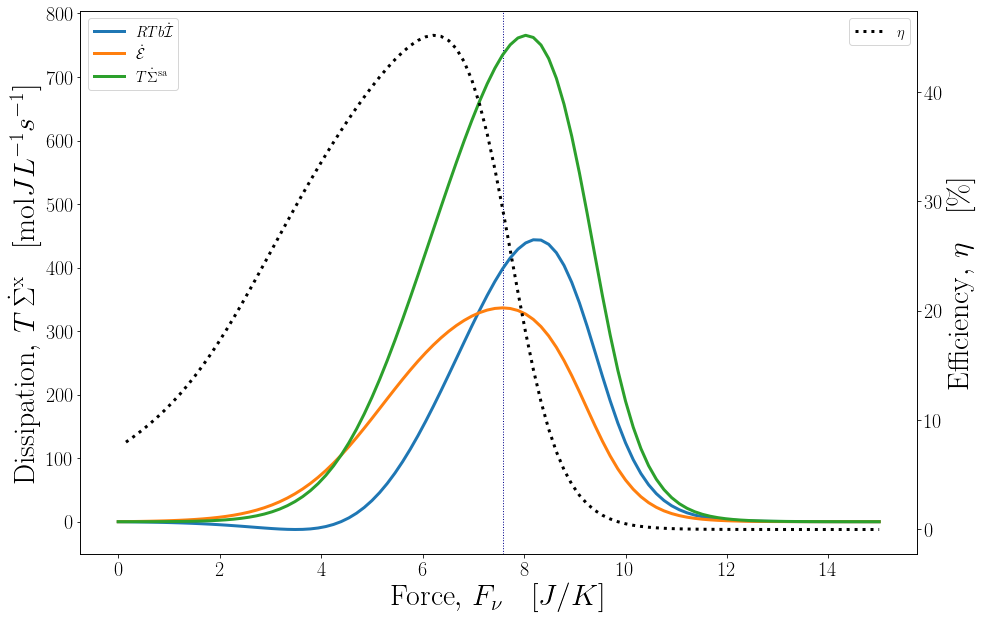

In [10]:
optAff = A.index(max(A))

infothermo, ax1 = plt.subplots(1,figsize=(15,10))
ax1.axvline(x=AFF[optAff], linewidth=1.0, color='darkblue', linestyle=':')
ax1.plot(AFF, INFOFLOW , linewidth=3.0, linestyle='solid', label='$RTb\dot{\mathcal{I}}$')
ax1.plot(AFF, EFLOW , linewidth=3.0, linestyle='solid', label='$\dot{\mathcal{E}}$')
ax1.plot(AFF, EPSA , linewidth=3.0, linestyle='solid', label='$T\dot{\Sigma}^\mathrm{sa}$')
ax1.set_xlabel('$\mathrm{Force}, \, F_\\nu \quad [J/K]$', size = 30)
ax1.set_ylabel('$\mathrm{Dissipation}, \, T\, \dot{\Sigma}^\mathrm{x} \quad [\mathrm{mol} J L^{-1} s^{-1}]$', size = 30)
ax1.tick_params('y', labelsize=20)
ax1.tick_params('x', labelsize=20)

ax2 = ax1.twinx()
ax2.plot(AFF, INTEFF, linewidth=3.0, linestyle=':', c='black', label='$\\eta$')
ax2.set_ylabel('$\mathrm{Efficiency}, \, \\eta \quad [\\%] $', size = 30)
ax2.tick_params('y', labelsize=20)

ax1.legend(loc=2, prop={'size': 15})
ax2.legend(loc=1, prop={'size': 15})

plt.show()